### Segmentation 04

- Application of 2D and 3D segmentation

In [23]:
%run ../utils.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from skimage import exposure
from skimage import measure
from skimage import segmentation

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'reg001_X01_Y01.tif'

# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle')
# #exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-tf-dynamic-psf', '2-Deconvolution')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# crop = [slice(0, 512), slice(0, 512)]
# #crop = [slice(None, None), slice(None, None)]
# tile_file = 'reg001_X01_Y01.tif'

#exp_name = '20180614_D23_RepA_Tcell_CD4-CD8-DAPI_5by5'
exp_name = '20180614_D22_RepA_Tcell_CD4-CD8-DAPI_5by5'
exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
#exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
nuc_cyc = 0
nuc_ch = 0
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(None, None), slice(None, None)]
tile_file = 'reg001_X02_Y01.tif'

model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [24]:
exp_conf = cytokit_config.load(exp_conf_dir)

In [25]:
import imp
imp.reload(cytokit_io)

<module 'cytokit.io' from '/lab/repos/cytokit/python/pipeline/cytokit/io.py'>

In [26]:
tile = cytokit_io.read_tile(osp.join(exp_data_dir, tile_file), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((1, 25, 3, 1008, 1344), dtype('uint8'))

In [27]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [28]:
exp_conf.channel_names[:10]

['DAPI', 'CD4', 'CD8']

In [29]:
img_nuc = tile[nuc_cyc, :, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)
img_nuc.shape, img_nuc.dtype

((25, 1008, 1344), dtype('uint8'))

In [43]:
from cytokit.cytometry import cytometer
import imp
imp.reload(cytometer)

<module 'cytokit.cytometry.cytometer' from '/lab/repos/cytokit/python/pipeline/cytokit/cytometry/cytometer.py'>

In [44]:
#cytom = cytometer.Cytometer3D(img_nuc.shape[1:] + (1,), model_path).initialize()
cytom = cytometer.Cytometer2D(img_nuc.shape[1:] + (1,), model_path).initialize()

In [46]:
%%time
#img_seg, img_pred, img_bin = cytom.segment(img_nuc)
#img_seg, img_pred, img_bin = cytom.segment(img_nuc, best_z=15, batch_size=8)
img_seg, img_pred, img_bin = cytom.segment(img_nuc, batch_size=8, min_size=12, nucleus_dilation=8, proba_threshold=[.5, .9, .5], return_masks=True)

CPU times: user 7.27 s, sys: 2.73 s, total: 9.99 s
Wall time: 9.78 s


In [373]:
# img_pred.shape
#cytokit_io.save_tile('/lab/data/probas.tif', np.moveaxis(img_pred, 3, 1)[np.newaxis])

In [33]:
img_seg.shape, img_bin.shape

((25, 2, 1008, 1344), (25, 4, 1008, 1344))

In [375]:
# img_seg_props = measure.regionprops(img_seg[:, 0])
# pd.Series([img_seg_props[i].filled_image.shape[0] for i in range(len(img_seg_props))]).value_counts()

In [34]:
# Use find boundaries in 2D because it seems buggy in 3D

#img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

img_border = np.stack([
    segmentation.find_boundaries(img_seg[i][0], mode='inner', background=img_seg.min())
    for i in range(img_nuc.shape[0])
], axis=0)
img_border.shape

(25, 1008, 1344)

In [35]:
img_bin.shape

(25, 4, 1008, 1344)

In [36]:
img_nuc_border = img_nuc.copy()
img_nuc_border = exposure.rescale_intensity(img_nuc_border, out_range=(0, 200)).astype(np.uint8)
#img_nuc_border[img_bin[:, 1] > 0] = 230
#img_nuc_border[img_bin[:, 0] > 0] = 210
img_nuc_border[img_border > 0] = 128
#img_nuc_border[img_seg[:, 0] == 0] = 0
img_nuc_border.dtype, img_nuc_border.shape

(dtype('uint8'), (25, 1008, 1344))

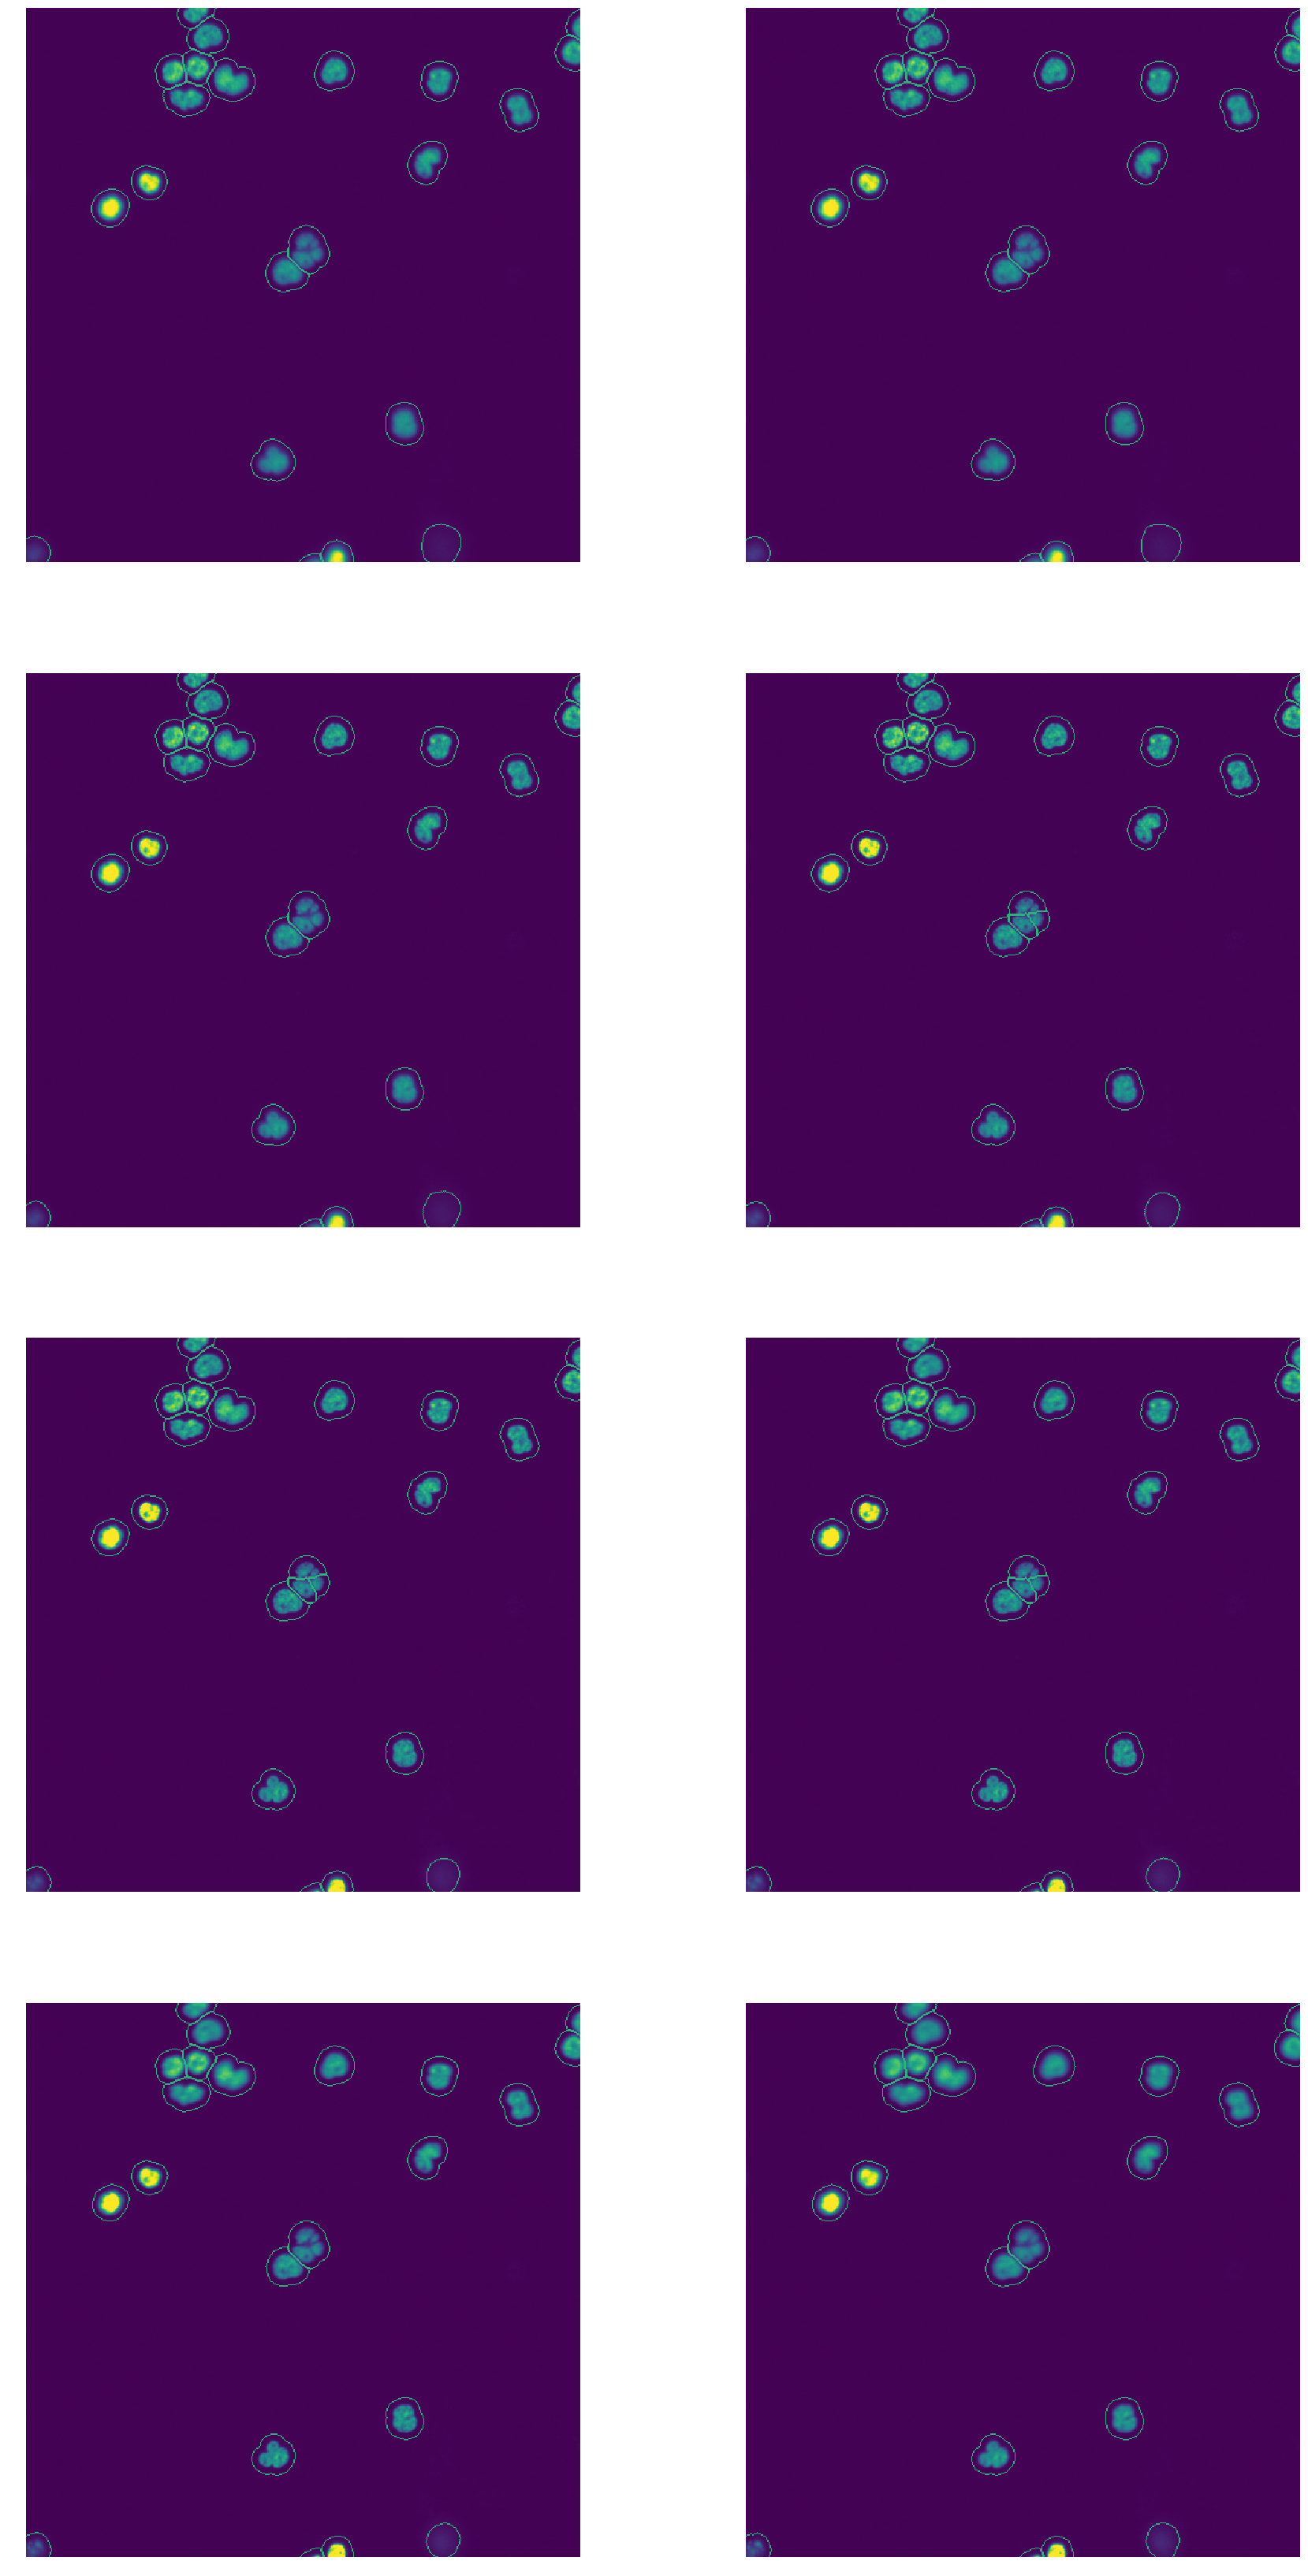

In [38]:
crop = [slice(0, 512), slice(0, 512)]
#crop = [slice(300, 400), slice(0, 256)]
visualize.display_images([
    img_nuc_border[i][crop]
    #for i in range(img_nuc_border.shape[0])
    for i in range(8)
], size=30, cols=2, cmap='viridis')

In [19]:
%%time
df = cytom.quantify(tile, img_seg)

CPU times: user 5.71 s, sys: 175 ms, total: 5.88 s
Wall time: 5.87 s


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 11 columns):
id                  3740 non-null int64
x                   3740 non-null float64
y                   3740 non-null float64
z                   3740 non-null int64
cell_size           3740 non-null int64
cell_solidity       3740 non-null float64
nucleus_size        3740 non-null int64
nucleus_solidity    3740 non-null float64
ch:000              3740 non-null float64
ch:001              3740 non-null float64
ch:002              3740 non-null float64
dtypes: float64(7), int64(4)
memory usage: 321.5 KB


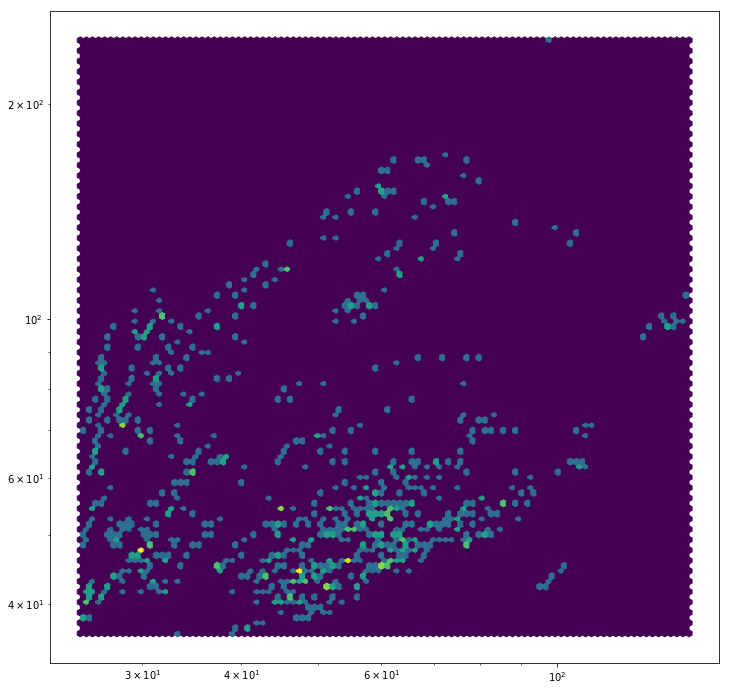

In [22]:
dfp = df[df['z'].between(13, 18)]
plt.hexbin(dfp['ch:001'], dfp['ch:002'], bins='log', xscale='log', yscale='log', cmap='viridis')
plt.gcf().set_size_inches(12, 12)